In [2]:
import os 
import yaml
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn-v0_8')
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

DATASETS = ['dataset-room1_512_16', 'dataset-room1_512_16_20', 'dataset-room1_512_16_8', 'dataset-room1_512_16_7', 'dataset-room1_512_16_6', 'dataset-room1_512_16_5', 'dataset-room1_512_16_4', 'dataset-room1_512_16_3', 'dataset-room1_512_16_2-5', 'dataset-room1_512_16_2']  #'dataset-room1_512_16_2'
#path_to_results = '../runs'
path_to_results = '/home/cm2113/workspace/results'
x = [0.0, 1.0/20.0, 1.0/8.0, 1./7., 1./6., 1./5., 1./4., 1./3., 1./2.5, 1./2.]


In [17]:
def extract_results(data_folder):
    runs = sorted(os.listdir(data_folder))
    scale_error, trans_error = [], []
    for run in runs: 
        path = f'{data_folder}/{run}/saved_results/traj_est/absolute_err_statistics_sim3_-1.yaml'
        with open(path) as f:
            data = yaml.load(f, Loader=yaml.loader.FullLoader)
            scale_error.append(data["scale"]['rmse'])
            trans_error.append(data['trans']['rmse'])
    return scale_error, trans_error

def plot_data_fill(mean, std, x_vec, imu):
    upper_limit = np.array(mean) + np.array(std) 
    lower_limit = np.array(mean) - np.array(std)
    plt.title(f'Translational error, with 10 itterations for each sequence')
    plt.plot(x_vec, mean, label = f'mean - {imu}')
    plt.fill_between(x_vec, upper_limit, lower_limit, alpha=0.3, label='sd')
    plt.xlabel('Time factor')
    plt.ylabel('Translational RMSE')

# at, only returning translational error statistics 
def compute_results(imu, system, sub='', dataset=None): 
    res_s, res_t = {}, {}
    std_s, std_t = {}, {}
    runs = {}
    datasets = [dataset] if dataset else DATASETS 
    
    for i in imu: 
        tot_s, tot_t = [], []
        s_s, s_t = [], []
        for dataset in datasets:
            data_folder = f'{path_to_results}/{dataset}/{system}/data{sub}/{i}'
            s, t = extract_results(data_folder)
            runs[dataset+i] = t
            tot_s.append(np.mean(s))
            tot_t.append(np.mean(t))
            s_s.append(np.std(s))
            s_t.append(np.std(t))
        res_s[i] = tot_s 
        res_t[i] = tot_t
        std_s[i] = s_s 
        std_t[i] = s_t
    return res_t, std_t, runs 


## ORB-SLAM Analysis 

In [35]:
system = 'orb_slam'
imu = ['withimu', 'withoutimu']

comp_orb_res_t, comp_orb_std_t, comp_orb_tot_t = compute_results(imu=imu, system=system, sub='/compensated10') 
noncomp_orb_res_t, noncomp_orb_std_t, noncomp_orb_tot_t = compute_results(imu=imu, system=system, sub='/noncompensated10') 
new_gt_t, new_gt_std_t, new_gt_tot_t = compute_results(imu=imu, system=system, sub='/noncompensated10_other_gt', dataset='dataset-room1_512_16')

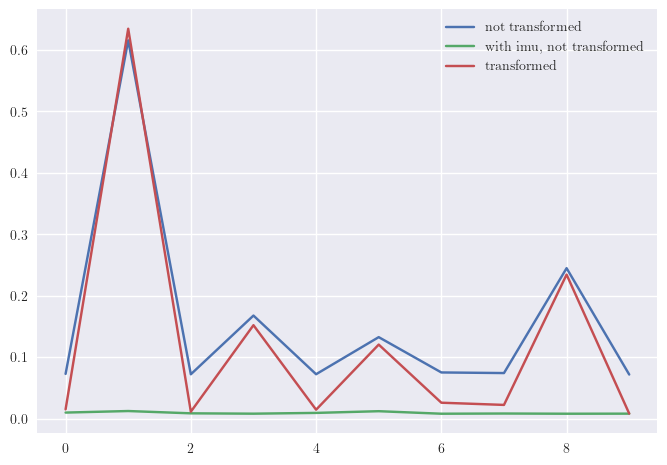

In [36]:
noncomp_orb_tot_t['dataset-room1_512_16withoutimu']
new_gt_tot_t['dataset-room1_512_16withoutimu']
plt.figure()
plt.plot(noncomp_orb_tot_t['dataset-room1_512_16withoutimu'], label='not transformed')
plt.plot(noncomp_orb_tot_t['dataset-room1_512_16withimu'], label='with imu, not transformed')
plt.plot(new_gt_tot_t['dataset-room1_512_16withoutimu'], label='transformed')
plt.legend()
plt.show()

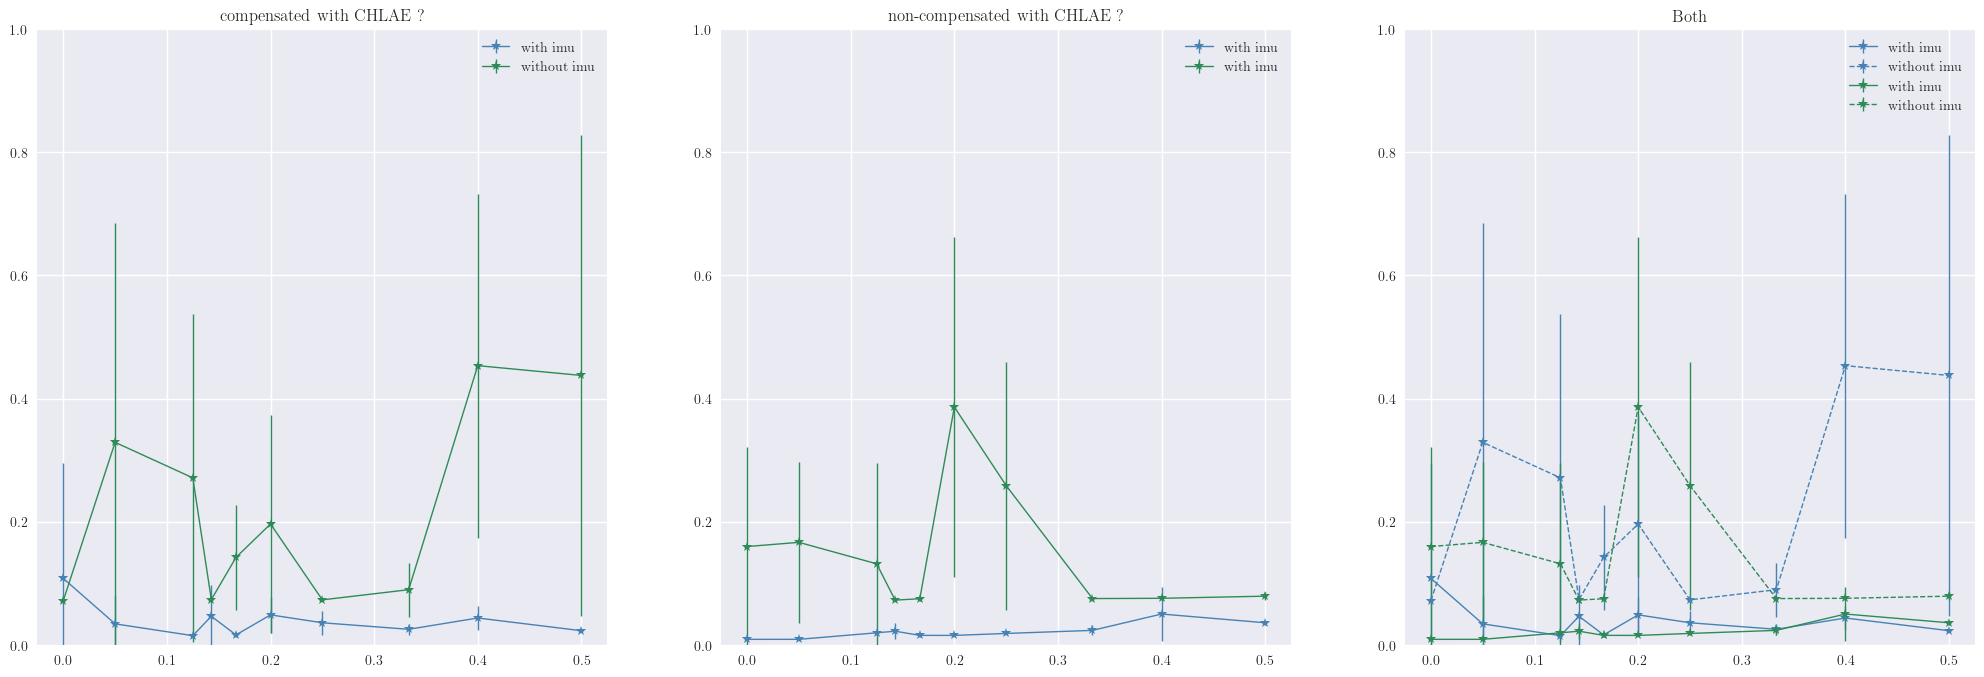

Mean compensated and with imu: 0.039773939085945
Mean not compensated and with imu: 0.022035395290961282
------------------------------------------------------------
Mean compensated and without imu: 0.2138613372318819
Mean not compensated and without imu: 0.14815392284758236


In [6]:
fig, ax = plt.subplots(1,3, figsize=(25,8))

ax[0].set_title('compensated with CHLAE ?')
ax[0].errorbar(x, comp_orb_res_t['withimu'], yerr=comp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[0].errorbar(x, comp_orb_res_t['withoutimu'], yerr=comp_orb_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
ax[0].set_ylim(0,1)
ax[0].legend() 

ax[1].set_title('non-compensated with CHLAE ?')
ax[1].errorbar(x, noncomp_orb_res_t['withimu'], yerr=noncomp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[1].errorbar(x, noncomp_orb_res_t['withoutimu'], yerr=noncomp_orb_std_t['withoutimu'], fmt='-*', label='with imu', lw=1, color='seagreen')
ax[1].set_ylim(0,1)
ax[1].legend() 

ax[2].set_title('Both')
ax[2].errorbar(x, comp_orb_res_t['withimu'], yerr=comp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
ax[2].errorbar(x, comp_orb_res_t['withoutimu'], yerr=comp_orb_std_t['withoutimu'], fmt='--*', label='without imu', lw=1, color='steelblue')
ax[2].errorbar(x, noncomp_orb_res_t['withimu'], yerr=noncomp_orb_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='seagreen')
ax[2].errorbar(x, noncomp_orb_res_t['withoutimu'], yerr=noncomp_orb_std_t['withoutimu'], fmt='--*', label='without imu', lw=1, color='seagreen')
ax[2].set_ylim(0,1)
ax[2].legend() 
plt.show()

print(f"Mean compensated and with imu: {np.mean(comp_orb_res_t['withimu'])}") 
print(f"Mean not compensated and with imu: {np.mean(noncomp_orb_res_t['withimu'])}") 
print("------------------------------------------------------------")
print(f"Mean compensated and without imu: {np.mean(comp_orb_res_t['withoutimu'])}") 
print(f"Mean not compensated and without imu: {np.mean(noncomp_orb_res_t['withoutimu'])}")

#### the rest are CLAHE compensated

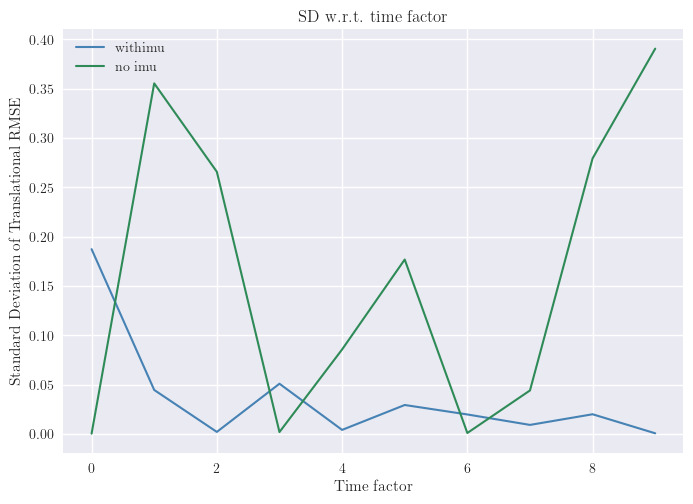

In [8]:
# Plot standard deviaton w.r.t time factor 
plt.figure()
plt.plot(comp_orb_std_t['withimu'], label='withimu', lw=1.5, color='steelblue')
plt.plot(comp_orb_std_t['withoutimu'], label='no imu', lw=1.5, color='seagreen')
plt.title('SD w.r.t. time factor')
plt.xlabel('Time factor')
plt.ylabel('Standard Deviation of Translational RMSE')
plt.legend()
plt.show()


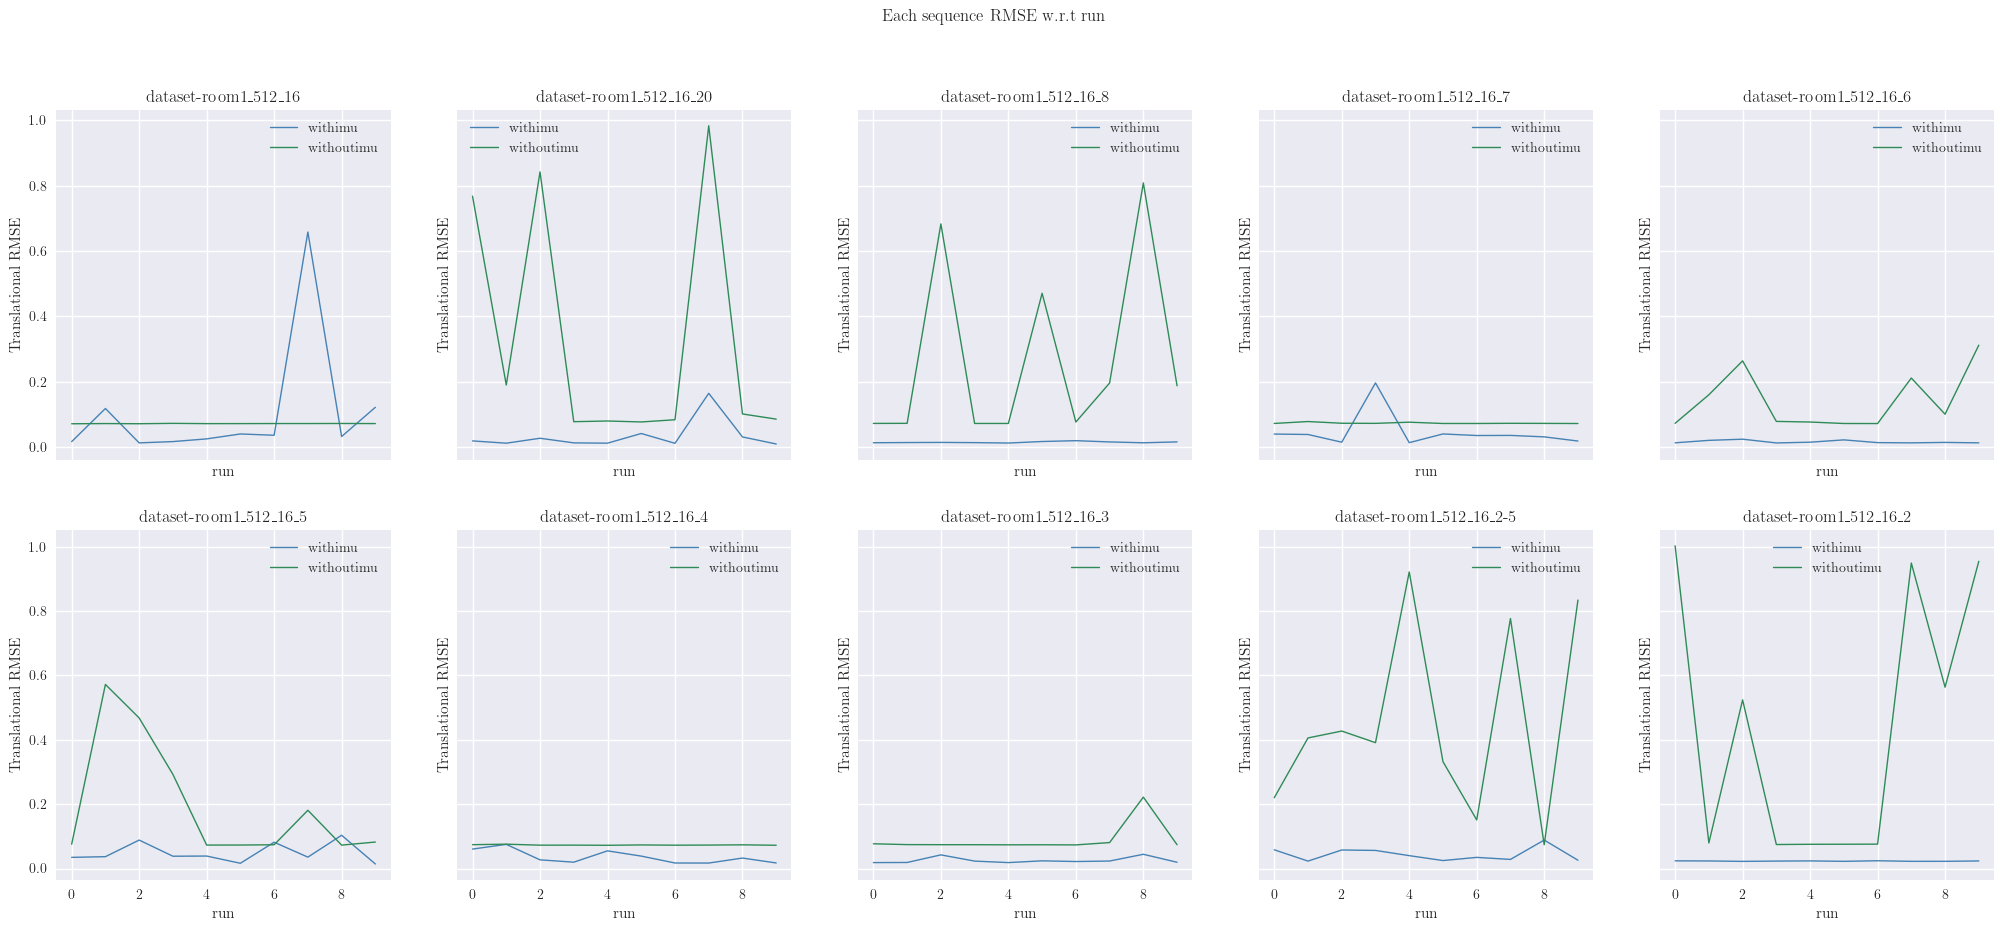

In [9]:
# plot the first sequence iterations in 'dataset-room1_512_16' - time factor 0 
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS[count]}')
        axis.plot(comp_orb_tot_t[f'{DATASETS[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(comp_orb_tot_t[f'{DATASETS[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

## DM-VIO Analysis 

In [33]:
system = 'dm_vio'
imu = ['withimu', 'withoutimu']

dm_res_t, dm_std_t, dm_tot_t = compute_results(imu=imu, system=system, sub='/photocalib10') 
new_gt_dm_res_t, new_gt_dm_std_t, new_gt_dm_tot_t = compute_results(imu=imu, system=system, sub='/nophotocalib_new_gt', dataset='dataset-room1_512_16') 
old_gt_dm_res_t, old_gt_dm_std_t, old_gt_dm_tot_t = compute_results(imu=imu, system=system, sub='/nophotocalib10_old_gt', dataset='dataset-room1_512_16') 

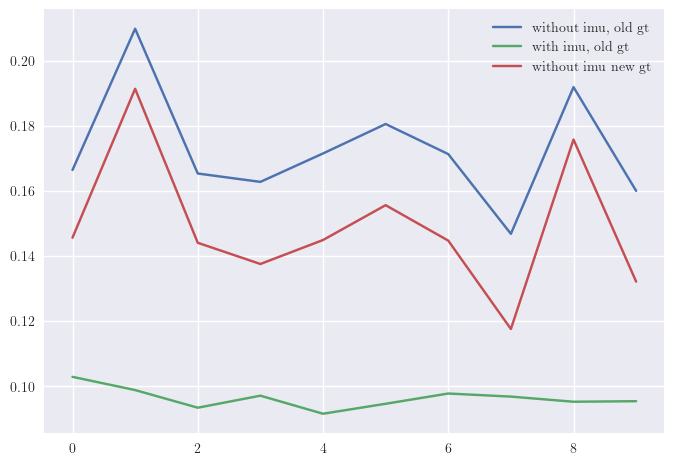

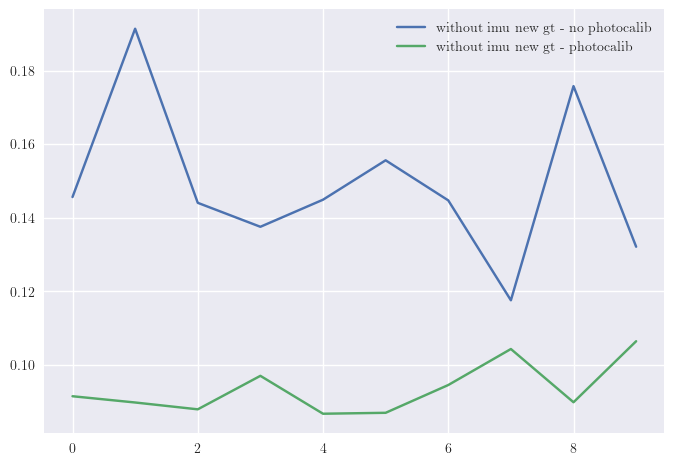

In [38]:
plt.plot(old_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu, old gt') 
plt.plot(old_gt_dm_tot_t['dataset-room1_512_16withimu'], label = 'with imu, old gt') 
plt.plot(new_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt')
plt.legend()
plt.show()

plt.figure()
plt.plot(new_gt_dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt - no photocalib')
plt.plot(dm_tot_t['dataset-room1_512_16withoutimu'], label = 'without imu new gt - photocalib')
plt.legend()
plt.show()

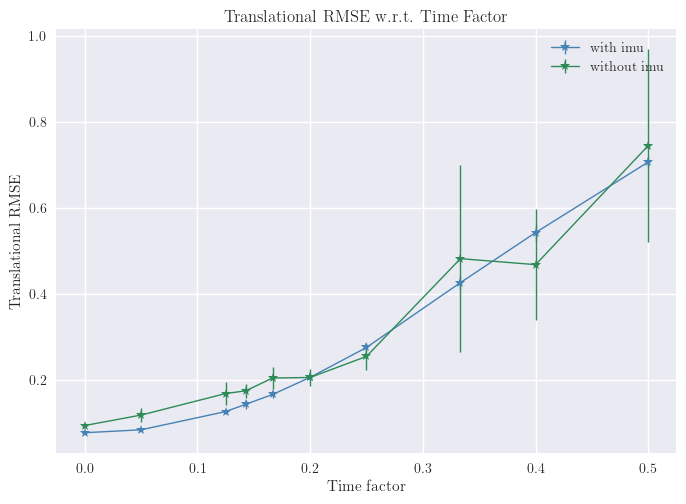

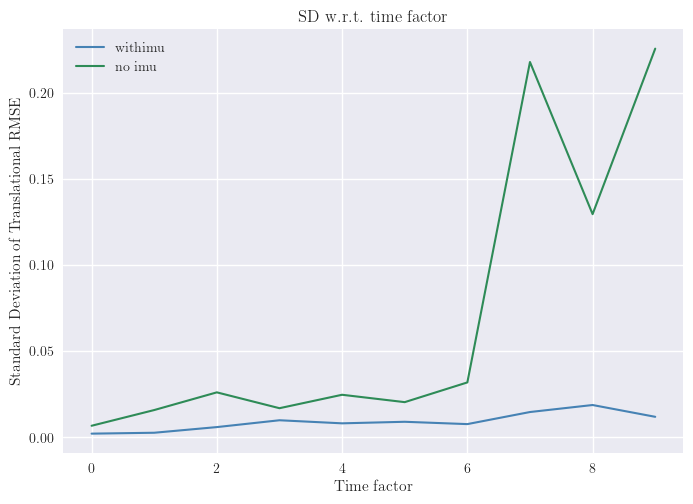

In [11]:
plt.figure()
plt.errorbar(x, dm_res_t['withimu'], yerr=dm_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, dm_res_t['withoutimu'], yerr=dm_std_t['withoutimu'], fmt='-*', label='without imu',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()


plt.figure()
plt.plot(dm_std_t['withimu'], label='withimu', lw=1.5, color='steelblue')
plt.plot(dm_std_t['withoutimu'], label='no imu', lw=1.5, color='seagreen')
plt.title('SD w.r.t. time factor')
plt.xlabel('Time factor')
plt.ylabel('Standard Deviation of Translational RMSE')
plt.legend()
plt.show()

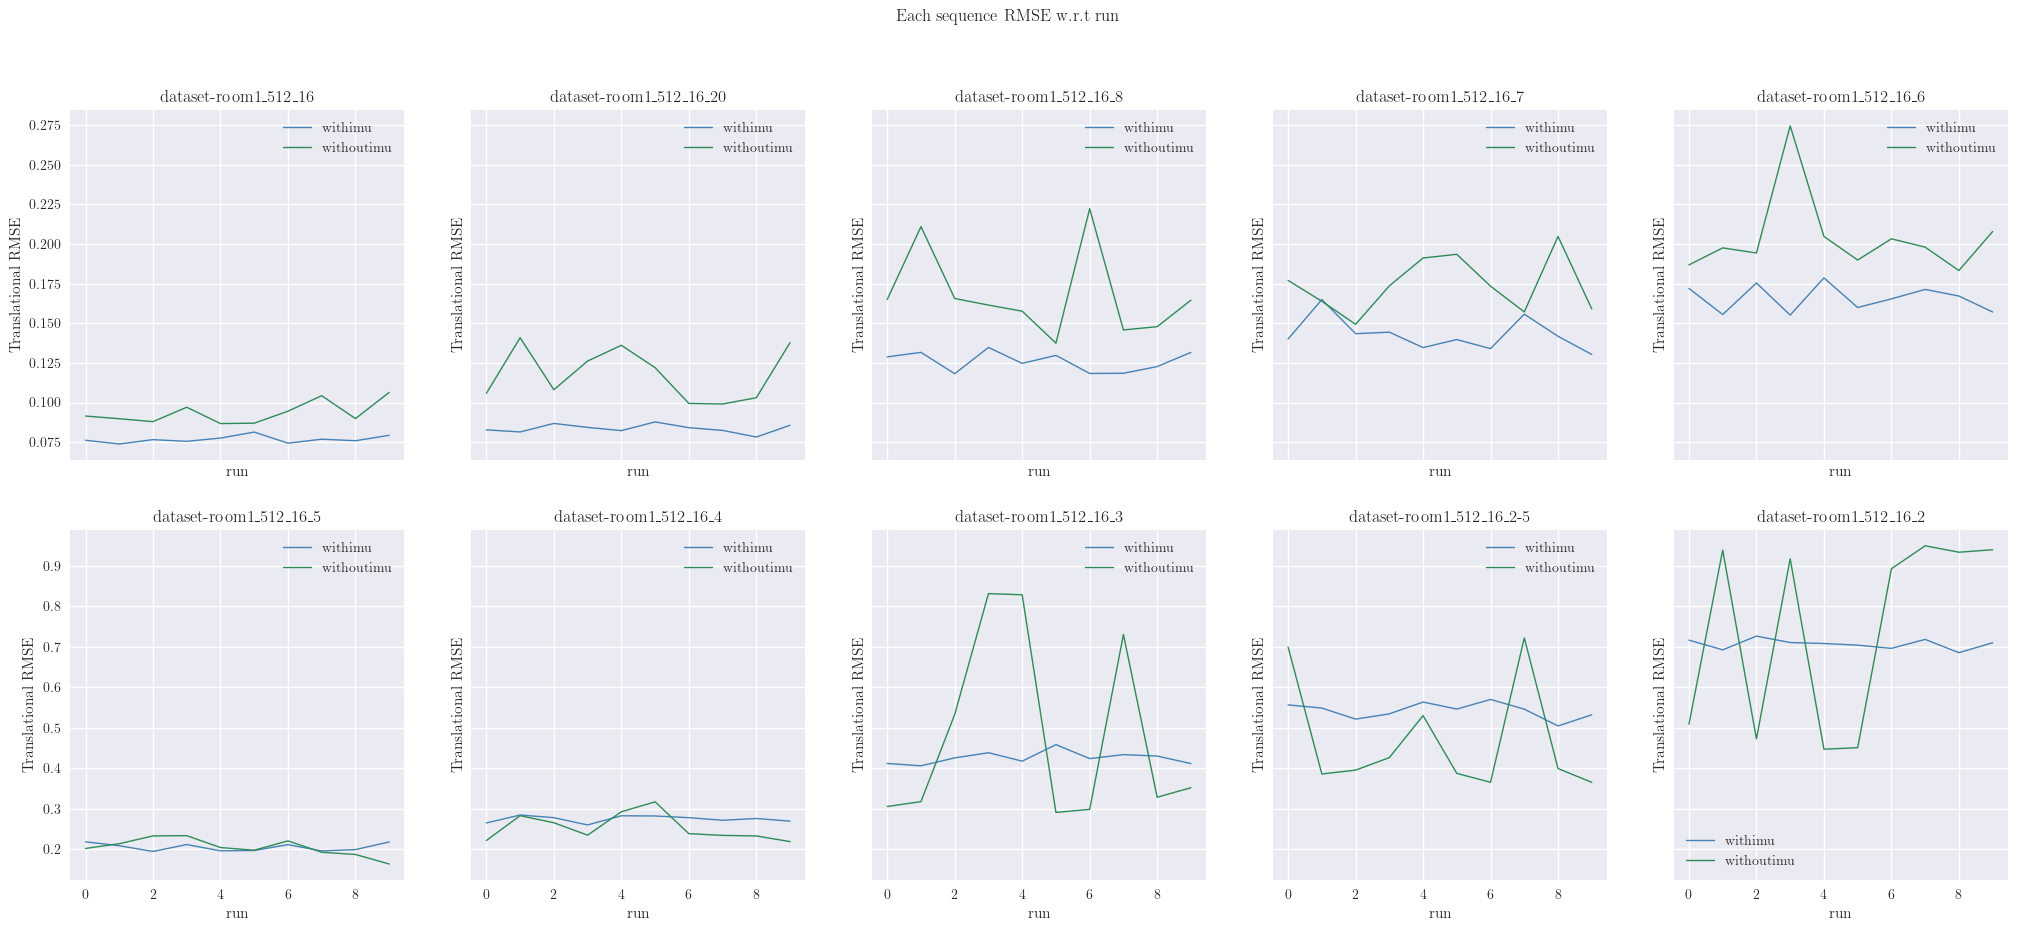

In [12]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(25, 10))
plt.suptitle('Each sequence RMSE w.r.t run')
count = 0 
for i in range(2):
    for j in range(5):
        axis = ax[i,j]
        axis.set_title(f'{DATASETS[count]}')
        axis.plot(dm_tot_t[f'{DATASETS[count]}withimu'],  label='withimu', lw=1, color='steelblue')
        axis.plot(dm_tot_t[f'{DATASETS[count]}withoutimu'],  label='withoutimu', lw=1, color='seagreen')
        axis.legend()
        axis.set_xlabel('run') 
        axis.set_ylabel('Translational RMSE')
        count += 1 

In [13]:
dm_nocalib_res_t, dm_nocalib_std_t, dm_nocalib_tot_t = compute_results(imu=['withimu'], system=system) 

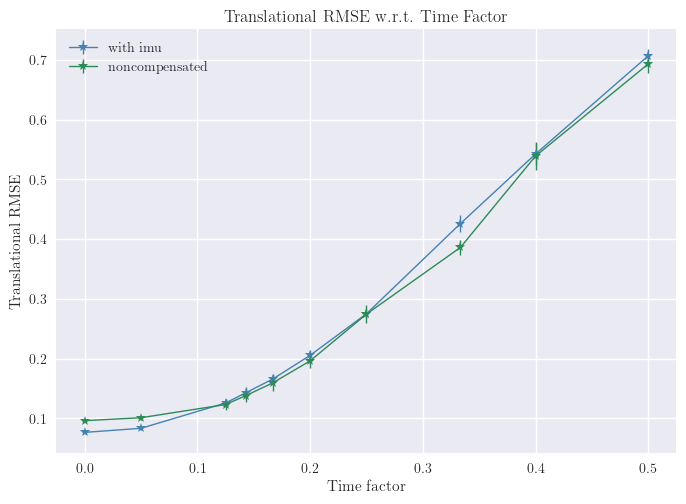

In [14]:
plt.figure()
plt.errorbar(x, dm_res_t['withimu'], yerr=dm_std_t['withimu'], fmt='-*', label='with imu', lw=1, color='steelblue')
plt.errorbar(x, dm_nocalib_res_t['withimu'], yerr=dm_nocalib_std_t['withimu'], fmt='-*', label='noncompensated',lw=1,color='seagreen')
plt.title('Translational RMSE w.r.t. Time Factor')
plt.xlabel('Time factor')
plt.ylabel('Translational RMSE')
plt.legend()
plt.show()

## Both 

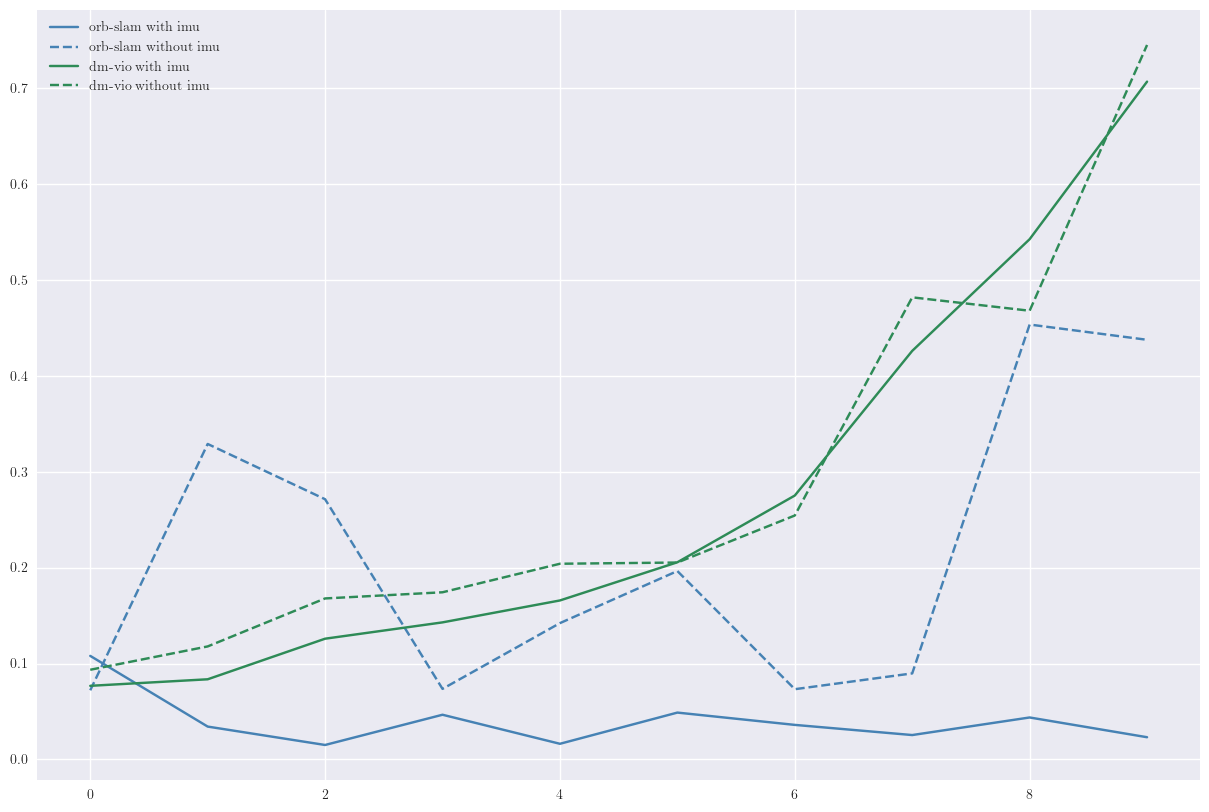

In [ ]:
plt.figure(figsize=(15,10))
# plot_data_fill(comp_orb_res_t['withimu'], comp_orb_std_t['withimu'], x, 'withimu')
# plot_data_fill(comp_orb_res_t['withoutimu'], comp_orb_std_t['withoutimu'], x, 'withoutimu')
# plot_data_fill(dm_res_t['withimu'], dm_std_t['withimu'], x, 'withimu')
# plot_data_fill(dm_res_t['withoutimu'], dm_std_t['withoutimu'], x, 'withoutimu')
plt.plot(comp_orb_res_t['withimu'], label='orb-slam with imu', color='steelblue')
plt.plot(comp_orb_res_t['withoutimu'], ls='--', label='orb-slam without imu', color='steelblue')
plt.plot(dm_res_t['withimu'], label='dm-vio with imu', color='seagreen')
plt.plot(dm_res_t['withoutimu'], ls='--', label='dm-vio without imu', color='seagreen')
plt.legend()
plt.show()